In [2]:
# !pip install lightgbm

In [3]:
import pandas as pd
import random
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [4]:
train=pd.read_csv('train_final.csv')
test=pd.read_csv('test_final.csv')
submit = pd.read_csv('sample_submission.csv')

In [5]:
# train = train.astype({'gender':object})
# train = train.astype({'car':object})
# train = train.astype({'reality':object})
# train = train.astype({'edu_type':object})
# train = train.astype({'work_phone':object})
# train = train.astype({'phone':object})
# train = train.astype({'email':object})
# train = train.astype({'family_size':object})  # 이산형
# train = train.astype({'credit':int})          # 타겟
# train = train.astype({'age':object})          # 이산형
# train = train.astype({'experience':object})   # 이산형
# train = train.astype({'start_work':object})   # 이산형
# train = train.astype({'n_card':object})       # 이산형
# train = train.astype({'extra_card':object})
# train = train.astype({'ability':object})      # 이산형
# train = train.astype({'owned':object})
# train = train.astype({'property':object})     # 이산형-> 점수?

In [6]:
X = train.drop('credit', axis=1)
y = train['credit'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
predicted = lgb.predict(X_test)

In [8]:
print(accuracy_score(y_test, predicted))

0.6972338006820765


In [9]:
# 최종예측 
predicted2 = lgb.predict(test)
predicted2

array([2., 2., 2., ..., 2., 2., 2.])

## GridSearchCV

In [10]:
lgb=LGBMClassifier()

In [11]:
params = {'max_depth':[10, 20, 30],    # 트리의 최대 깊이
          'num_leaves':[20,40],        # 하나의 트리가 가질 수 있는 최대 리프 개수
          'n_estimators':[20,40,60],   # 반복하려는 트리의 개수 
          'min_child_samples':[5,10],  # 리트 노드가 되기 위한 최소한의 샘플 데이터 수 
          'learning_rate':[0.05,0.1],  # 학습률
          'reg_alpha':[0,0.01]           # L1 regularization
          #'reg_lambda':[0,0.01,0.03]}   # L2 regularization
         }      

In [12]:
clf=GridSearchCV(lgb, params, scoring='accuracy')

In [13]:
clf.fit(X=X_train, y=y_train) 
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 10, 'n_estimators': 60, 'num_leaves': 40, 'reg_alpha': 0.01}


In [14]:
params['num_leaves'] = clf.best_params_['num_leaves']
params['n_estimators'] = clf.best_params_['n_estimators'] 
params['min_child_samples'] = clf.best_params_['min_child_samples']
params['max_depth'] = clf.best_params_['max_depth']
params['learning_rate'] = clf.best_params_['learning_rate']
params['reg_alpha'] = clf.best_params_['reg_alpha']

In [15]:
model = LGBMClassifier(**params, random_state=123)
model.fit(X_train, y_train) 

LGBMClassifier(max_depth=20, min_child_samples=10, n_estimators=60,
               num_leaves=40, random_state=123, reg_alpha=0.01)

In [16]:
predicted = model.predict(X_test) 
print(accuracy_score(y_test, predicted))

0.6962864721485411


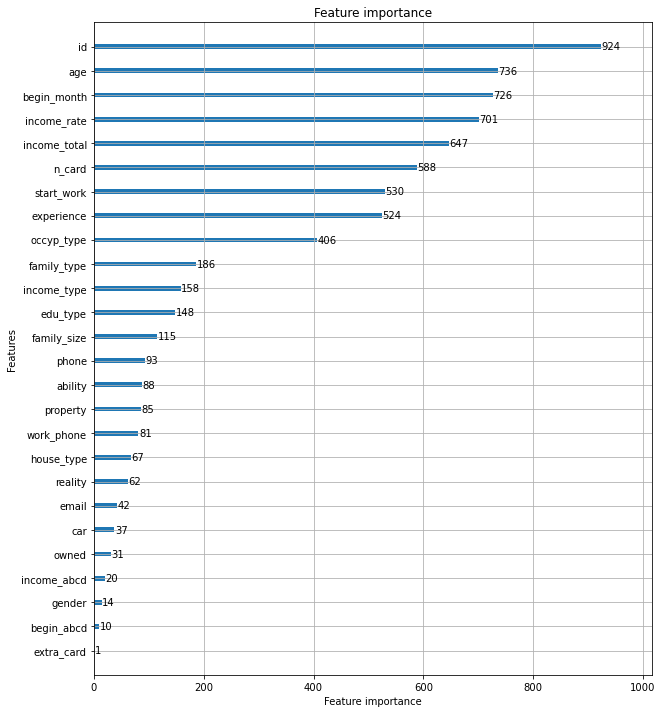

In [17]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(model, ax=ax)
plt.show()

## Random Search

In [18]:
lgb=LGBMClassifier()

In [19]:
params = {'max_depth':[10,20,30,40],   # 트리의 최대 깊이
          'num_leaves':[20,40],        # 하나의 트리가 가질 수 있는 최대 리프 개수
          'n_estimators':[20,40,60,80,100,200],   # 반복하려는 트리의 개수 
          'min_child_samples':[5,10],  # 리트 노드가 되기 위한 최소한의 샘플 데이터 수 
          'learning_rate':[0.05,0.1],  # 학습률
          'reg_alpha':[0,0.01]           # L1 regularization
          #'reg_lambda':[0,0.01,0.03]}   # L2 regularization
         }    

In [20]:
clf=RandomizedSearchCV(lgb,params,scoring='accuracy',n_iter=20, random_state=123)

In [21]:
clf.fit(X=X_train, y=y_train) 
print(clf.best_params_)

{'reg_alpha': 0.01, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.1}


In [22]:
params['num_leaves'] = clf.best_params_['num_leaves']
params['n_estimators'] = clf.best_params_['n_estimators'] 
params['min_child_samples'] = clf.best_params_['min_child_samples']
params['max_depth'] = clf.best_params_['max_depth']
params['learning_rate'] = clf.best_params_['learning_rate']
params['reg_alpha'] = clf.best_params_['reg_alpha']

In [23]:
model = LGBMClassifier(**params, random_state=123)
model.fit(X_train, y_train) 

LGBMClassifier(max_depth=10, min_child_samples=10, n_estimators=200,
               num_leaves=40, random_state=123, reg_alpha=0.01)

In [24]:
predicted = model.predict(X_test) 
print(accuracy_score(y_test, predicted))

0.7038651004168246


In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
folds=[]
for train_idx, test_idx in skf.split(train, train['credit']):
    folds.append((train_idx, test_idx))

In [26]:
random.seed(123)
lgb_models={}
for fold in range(5):
    print("---------------------------------------")
    train_idx, test_idx = folds[fold]
    X_train, X_test, y_train, y_test = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[test_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][test_idx].values 
    lgb = LGBMClassifier(**params)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb

---------------------------------------


C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's multi_logloss: 0.596905	valid_1's multi_logloss: 0.749215
[200]	training's multi_logloss: 0.493683	valid_1's multi_logloss: 0.739833
---------------------------------------


C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's multi_logloss: 0.603522	valid_1's multi_logloss: 0.739663
[200]	training's multi_logloss: 0.497038	valid_1's multi_logloss: 0.72666
---------------------------------------


C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's multi_logloss: 0.601954	valid_1's multi_logloss: 0.734847
[200]	training's multi_logloss: 0.496197	valid_1's multi_logloss: 0.725028
---------------------------------------


C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's multi_logloss: 0.601058	valid_1's multi_logloss: 0.740715
[200]	training's multi_logloss: 0.499546	valid_1's multi_logloss: 0.729222
---------------------------------------


C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\seohyun\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's multi_logloss: 0.601049	valid_1's multi_logloss: 0.744089
[200]	training's multi_logloss: 0.496212	valid_1's multi_logloss: 0.733343


In [27]:
predicted = lgb.predict(X_test) 
print(accuracy_score(y_test, predicted))

0.7087360242562062


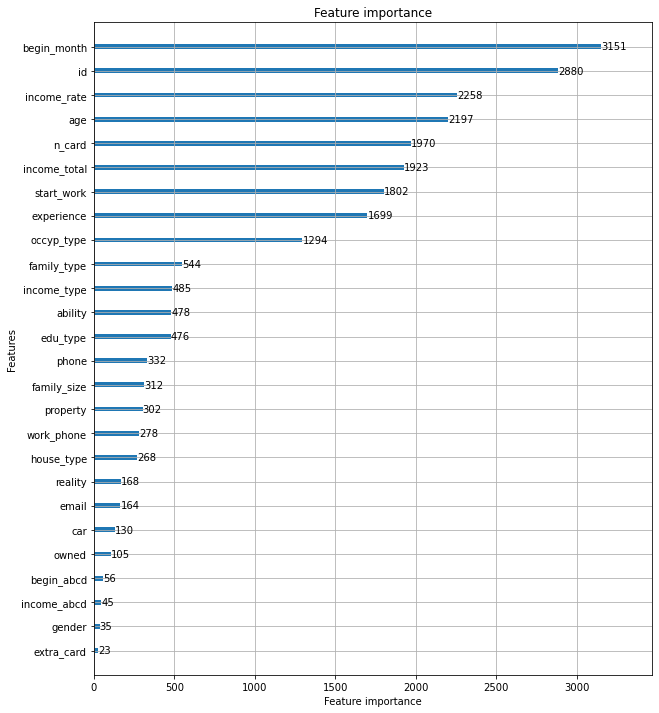

In [28]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(model, ax=ax)
plt.show()

In [29]:
submit.iloc[:,1:]=0

In [30]:
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [31]:
submit

,index,0,1,2
0,26457,0.066919,0.224693,0.708388
1,26458,0.042077,0.141899,0.816024
2,26459,0.087561,0.209338,0.703101
3,26460,0.138852,0.143517,0.717632
4,26461,0.107901,0.164946,0.727153
...,...,...,...,...
9995,36452,0.217960,0.098700,0.683340
9996,36453,0.114293,0.236486,0.649221
9997,36454,0.123039,0.175689,0.701273
9998,36455,0.084062,0.091383,0.824554


In [32]:
submit.to_csv('submission_final.csv', index=False)